In [1]:
%matplotlib inline
import os
import joblib
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.signal import gaussian, find_peaks
from scipy.ndimage import filters

from sklearn.utils import resample

save = False

cm = 1/2.54  # centimeters in inches
sns.set_context('paper', rc={'font.size': 10, 'xtick.labelsize': 8, 'ytick.labelsize': 8,
                          'figure.titleweight': 'bold', 'axes.labelsize':10, 'axes.titlesize':12})


dir_path = os.path.abspath('')

output_path = dir_path + '/Figures/'

In [2]:
def smooth_response(response, filterWidth=8):
    """

    :param response: Trials x Times
    :param filterWidth: SD of Gaussian
    :return: Smoothed response
    """
    if len(response.shape) == 1:
        response = response[np.newaxis, :]
    gauss = gaussian(10 * filterWidth, filterWidth)
    return filters.convolve1d(response, gauss / gauss.sum(), axis=1)


def estimateLatency(data, data_baseline, start_eval=145, filterWidth=8, prestimulus_correct=True):
    """

    :param resp: Spike counts, images x times
    :param image_onset: sample when the image started
    :param start_eval: sample from which to start estimating the latency
    :param filterWidth: SD of gaussian for smoothing
    :param baseline_period: Time to estimate the response variability during no stimulation
    :return: Latencies and local maxima per image.
    """
   
    # Smooth with gaussian of 8 ms
    data = smooth_response(np.array(data, dtype=float), filterWidth=filterWidth)

    
    # Determine the SEM in the baseline period across all images, This is different from Sundberg et al..
    if prestimulus_correct == True:
        #data_baseline = data_baseline - np.mean(data_baseline[:, 50:100], axis=1)[:,np.newaxis]
        data = data - np.mean(data[:, 50:100], axis=1)[:, np.newaxis]

    latencies = np.full(len(data), np.nan)
    local_maxima = np.full(len(data), np.nan)
    for i in range(len(data)):
        
        data_baseline_t = smooth_response(np.array(data_baseline[i].T, dtype=float), filterWidth=filterWidth)
        if prestimulus_correct == True:
            data_baseline_t = data_baseline_t - np.mean(data_baseline_t[:, 50:100], axis=1)[:, np.newaxis]

        # define the criterion
        
        mean_baseline = np.mean(data_baseline_t[:,start_eval:])
        criterion = np.percentile(data_baseline_t[:,start_eval:].flatten(), (1 - 0.0001)*100)
        

        # Find all peaks
        l_id, peaks = find_peaks(data[i, start_eval:], height=criterion)

        # Find the mid-point
        if len(l_id) > 0:
            l_id = l_id + start_eval  # bring back to the original time

            midpoint = (peaks['peak_heights'][0] - mean_baseline) * 0.5 + mean_baseline
            # Find zero-crossing
            crossings = np.intersect1d((np.where((data[i, start_eval:l_id[0]] - midpoint) >= 0)[0]),
                                  (np.where((data[i, start_eval:l_id[0]] - midpoint) < 0)[0] + 1))
            if len(crossings) > 0:
                latencies[i] = crossings[-1] + start_eval
           
            local_maxima[i] = l_id[0]

        else:
            pass
            #print(str(i) + ': No local minima identified.')

        
    return latencies, local_maxima


In [3]:
tracker = joblib.load(dir_path + '/ModelAnalysis/FiringRates_readout.pkl')

colors = sns.color_palette(sns.xkcd_palette([ "orange yellow","windows blue", "greyish", "faded green", "dusty purple","orange", "grey"]))

In [4]:
offset = 0
onset = 100
l = 25
time_steps = np.arange(-onset, tracker['neutral']['MUA'].shape[1] - onset) 
n = tracker['neutral']['MUA'].shape[0]

conds = ['precision', 'inputGain', 'outputGain']
start_eval = 100

latencies = pd.DataFrame(np.full((len(conds) * 2 * n, 5), np.nan),
                       columns=['Mechanism', 'Attention', 'Trial', 'Latency', 'Peak'])

latencies['Attention'] = np.repeat(np.arange(2)[np.newaxis, :], len(conds) * n, axis=0).flatten()
latencies['Mechanism'] = np.repeat(np.arange(len(conds))[np.newaxis, :], 2 * n, axis=1).flatten()
latencies['Trial'] = np.repeat(np.repeat(np.arange(n)[:,np.newaxis],2).flatten()[np.newaxis,:], len(conds), axis=0).flatten()


replace_map = {'Attention': {0: 'valid', 1:'invalid'},
               'Mechanism': {0: conds[0], 1: conds[1], 2: conds[2]}}

latencies.replace(replace_map, inplace=True)


latencies_n, local_maxima_n = estimateLatency(tracker['neutral']['MUA'][:n],
                                                      tracker['neutral']['MUA_baseline_average'][:, :,
                                                      tracker['locations'][:, 0], tracker['locations'][:, 1]].T,
                                                      start_eval=start_eval)
latencies_n[latencies_n <= start_eval] = np.nan
local_maxima_n[latencies_n <= start_eval] = np.nan


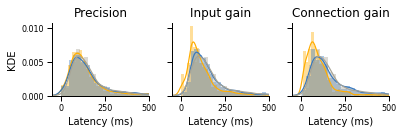

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(14.5*cm, 5*cm), sharey=True, sharex=True)
ax = ax.flatten()

for c, cond in enumerate(conds):

    latencies_v, local_maxima_v = estimateLatency(tracker[cond]['valid']['MUA'][:n],
                                                  tracker[cond]['valid']['MUA_baseline_average'][:, :,
                                                  tracker['locations'][:, 0], tracker['locations'][:, 1]].T,
                                                  start_eval=start_eval)
    # filter out the pre-stimulus responses
    latencies_v[latencies_v <= start_eval] = np.nan
    local_maxima_v[latencies_v <= start_eval] = np.nan

    latencies_i, local_maxima_i = estimateLatency(tracker[cond]['invalid']['MUA'][:n],
                                                  tracker[cond]['invalid']['MUA_baseline_average'][:, :,
                                                  tracker['locations'][:, 0], tracker['locations'][:, 1]].T,
                                                  start_eval=start_eval)
    latencies_i[latencies_i <= start_eval] = np.nan
    local_maxima_i[latencies_i <= start_eval] = np.nan

    sns.distplot(latencies_v - onset, color=colors[0], label='valid', ax=ax[c])
    sns.distplot(latencies_i - onset, color=colors[1], label='invalid', ax=ax[c])
    sns.distplot(latencies_n - onset, color=colors[2], label='neutral', ax=ax[c])

    latencies.loc[(latencies['Mechanism'] == cond) & (latencies['Attention'] == 'valid'), 'Latency'] = latencies_v
    latencies.loc[(latencies['Mechanism'] == cond) & (latencies['Attention'] == 'invalid'), 'Latency'] = latencies_i
    # latencies.loc[(latencies['Mechanism'] == cond) & (latencies['Attention'] == 'neutral'), 'Latency'] = latencies_n

    latencies.loc[(latencies['Mechanism'] == cond) & (latencies['Attention'] == 'valid'), 'Peak'] = local_maxima_v
    latencies.loc[(latencies['Mechanism'] == cond) & (latencies['Attention'] == 'invalid'), 'Peak'] = local_maxima_i
   
    ax[c].set_xlim([-50, 500])
    ax[c].set_xticks([0, 250, 500])
    sns.despine(ax=ax[c])


ax[0].set_ylabel('KDE')
ax[0].set_xlabel('Latency (ms)')
ax[0].set_title('Precision')


ax[1].set_title('Input gain')
ax[1].set_xlabel('Latency (ms)')

ax[2].set_title('Connection gain')
ax[2].set_xlabel('Latency (ms)')

sns.despine()


plt.subplots_adjust(wspace=0.01,hspace=0.01)
plt.tight_layout()
if save == True:
    fig.savefig(output_path + 'Latencies_allConditions_neutral.pdf', dpi=300, transparent=True)
else:
    plt.show()


In [ ]:
medians = latencies.groupby(['Mechanism', 'Attention'])['Latency'].median() - 100
print(medians)
latencies['Missing'] = latencies['Latency'].isna()

print(latencies.groupby(['Mechanism', 'Attention'])['Missing'].sum())

latencies['Latency'] = latencies['Latency'] - onset

Mechanism   Attention
inputGain   invalid      123.0
            valid         93.0
outputGain  invalid      123.0
            valid         82.0
precision   invalid      125.0
            valid        115.0
Name: Latency, dtype: float64
Mechanism   Attention
inputGain   invalid       96.0
            valid         34.0
outputGain  invalid       96.0
            valid         25.0
precision   invalid      112.0
            valid         55.0
Name: Missing, dtype: float64


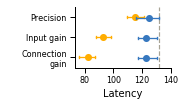

In [7]:

dodge = True
capsize = 0.1
aspect = 1.7  
errwidth = 1.3  

g = sns.catplot(y="Mechanism", x="Latency", hue="Attention", data=latencies[latencies['Attention'] != 'neutral'],
                height=4 * cm, aspect=aspect, kind="point",
                palette={'valid': colors[0], 'invalid': colors[1], 'neutral': colors[2]},
                legend=False, zorder=6, estimator=np.median, join=False, dodge=dodge,
                capsize=capsize, errwidth=errwidth, orient='h')

g.set_yticklabels(['Precision', 'Input gain', 'Connection\ngain'])

mean = np.nanmedian(latencies_n) - onset

g.ax.set_xticks([80, 100, 120, 140])
g.ax.set_xlabel('Latency')
g.ax.set_ylabel(' ')
g.ax.axvline(mean, c=colors[2], ls='--', zorder=0)

plt.tight_layout()

sns.despine(top=True, right=True)
if save == True:
    g.savefig(output_path + 'Latencies_' + mode + '.pdf', dpi=300, transparent=True)
else:
    plt.show()


In [7]:
import random

comps = ['valid vs invalid','invalid vs neutral', 'valid vs neutral']
results = {}
results_df = pd.DataFrame([], columns=['Mechanism', 'Comparison', 'Difference', 'p-values', 'significant'])

# Define p (number of permutations):
p = 10000

results['Permutations'] = p
results['alpha-level'] = 0.05 / len(comps)

neutralPreds = latencies_n - onset
for cond in conds:
    if cond not in results:
        results[cond] = {}
    print(cond)
    validPreds = latencies.loc[(latencies['Mechanism']==cond) & (latencies['Attention']=='valid'), 'Latency'].values
    invalidPreds = latencies.loc[(latencies['Mechanism']==cond) & (latencies['Attention']=='invalid'), 'Latency'].values
    idx = np.arange(len(validPreds) * 2)
    for comp in comps:
        if comp not in results[cond]:
            print(comp)
            if comp == 'valid vs invalid':
                diff = np.abs(np.nanmedian(validPreds) - np.nanmedian(invalidPreds))
                samplePreds = np.concatenate([validPreds, invalidPreds], axis=0)
            elif comp == 'valid vs neutral':
                diff = np.abs(np.nanmedian(neutralPreds) - np.nanmedian(validPreds))
                samplePreds = np.concatenate([validPreds, neutralPreds], axis=0)
            elif comp == 'invalid vs neutral':
                diff = np.abs(np.nanmedian(neutralPreds) - np.nanmedian(invalidPreds))
                samplePreds = np.concatenate([invalidPreds, neutralPreds], axis=0)

            else:
                raise ValueError('Comparison is not specified.')

            # Initialize permutation:
            pD = []

            # Permutation loop:
            for i in range(0, p):
                random.shuffle(idx)
                pD.append(np.abs(np.nanmedian(samplePreds[idx[:int(len(idx)//2)]]) - np.nanmedian(samplePreds[idx[int(len(idx) // 2):]])))

            p_val = len(np.where(pD>=diff)[0])/p
            print(cond + ': ' + str(p_val))

            results[cond][comp] = {}
            results[cond][comp]['Observed difference'] = diff
            results[cond][comp]['Difference distribution'] = pD
            results[cond][comp]['p-value']= p_val

            results_df = results_df.append({'Mechanism':cond, 'Comparison':comp, 'Difference':diff, 'p-values':p_val, 'significant':p_val<results['alpha-level']},ignore_index=True )


joblib.dump(results,
            dir_path + '/ModelAnalysis/LatencyPermutationTestsComparisons.pkl',
            compress=True)
results_df.to_csv(dir_path + '/ModelAnalysis/LatencyPermutationTestsComparisons_df.csv')


precision
valid vs invalid


precision: 0.0
valid vs neutral


precision: 0.0006
invalid vs neutral


precision: 0.0
inputGain
valid vs invalid


KeyboardInterrupt: 